<H1>How much Spam with your Ham? How Much SMS are you Willing to Lose for Zero Spam?</H1>

Note: you can install the requirements file for this notebook if you want to install all the libraries at once. Open a new terminal window, navigate to the folder with the "requirements_jupyter.txt" and run the following command:

pip3 install -r requirements_jupyter.txt

In [1]:
# !pip3 install -r requirements_jupyter.txt

Interactive spam detection and the relationship between true and false positives, or the tolerance for how much spam are we willing to tolerate in order to miss the least amount of ham messages.


**Download the SMS Spam Collection from the UCI Machine Learning Repository**

In [1]:
import matplotlib.pyplot as plt
from urllib.request import urlopen
from zipfile import ZipFile

# This is a zip file 
# if you cannot download the files try doing it manually
# if have an ssl error  Mac try fix: "/Applications/Python\ 3.6/Install\ Certificates.command"
sms_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
from io import BytesIO
url = urlopen(sms_url)
# Download the file from the URL
zipfile = ZipFile(BytesIO(url.read()))

In [2]:
import pandas as pd
import csv
sms_df = pd.read_csv(zipfile.open('SMSSpamCollection'), sep='\t', quoting=csv.QUOTE_NONE, names=["outcome", "sms"])
print (sms_df.head())

  outcome                                                sms
0     ham  Go until jurong point, crazy.. Available only ...
1     ham                      Ok lar... Joking wif u oni...
2    spam  Free entry in 2 a wkly comp to win FA Cup fina...
3     ham  U dun say so early hor... U c already then say...
4     ham  Nah I don't think he goes to usf, he lives aro...


**Exploring the Data**

In [3]:
sms_df.describe()

,outcome,sms
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


In [4]:
sms_df.groupby('outcome').describe()

sms                                                               
        count unique                                                top freq
outcome                                                                     
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

**Remove duplicate rows**

In [5]:
# remove duplicate rows
print('Duplicates found before clean-up: %i ' % sum(sms_df.duplicated()))
sms_df = sms_df.drop_duplicates(keep='first') 
print('Duplicates found after clean-up: %i ' % sum(sms_df.duplicated()))


Duplicates found before clean-up: 403 
Duplicates found after clean-up: 0 


**Let's Create New Features to Better Understand these SMSs**

In [6]:
# get word counts for each SMS
sms_df['word_count'] = [len(x.split()) for x in sms_df['sms']]

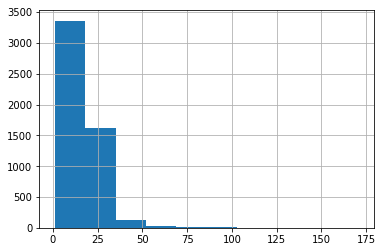

In [7]:
sms_df['word_count'].hist().plot()
plt.show()

In [8]:
# so any interesting differences between real and spam messages?
sms_df[['outcome', 'word_count']].groupby('outcome').describe()

word_count                                                    
             count       mean        std  min   25%   50%   75%    max
outcome                                                               
ham         4518.0  14.233289  11.161623  1.0   7.0  11.0  19.0  171.0
spam         653.0  23.739663   5.931064  2.0  22.0  25.0  28.0   35.0

In [9]:
# get character counts for each SMS
sms_df['character_count'] = [len(x) for x in sms_df['sms']]

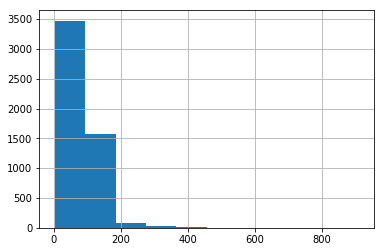

In [10]:
sms_df['character_count'].hist().plot()
plt.show()

In [11]:
# so any interesting differences between real and spam messages?
sms_df[['outcome', 'character_count']].groupby('outcome').describe()


character_count                                                    \
                  count        mean        std   min    25%    50%    75%   
outcome                                                                     
ham              4518.0   70.894865  56.590179   2.0   34.0   53.0   91.0   
spam              653.0  137.710567  29.818940  13.0  132.0  148.0  157.0   

                
           max  
outcome         
ham      910.0  
spam     223.0

In [12]:
# number of capital letters in SMS message
sms_df['capitals_count'] = [sum(1 for c in x if c.isupper()) for x in sms_df['sms']]

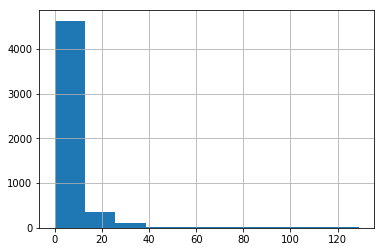

In [13]:
sms_df['capitals_count'].hist().plot()
plt.show()

In [14]:
# number of capital letters in SMS message
import string
sms_df['punctuation_count'] = [sum(1 for c in x if c in string.punctuation) for x in sms_df['sms']]

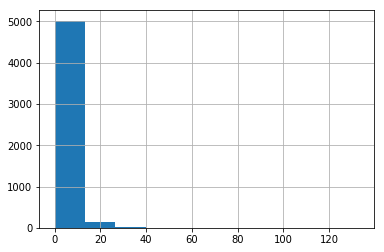

In [15]:
sms_df['punctuation_count'].hist().plot()
plt.show()

**Let's create a list of common Spam words**

Besides engineering features, a useful approach is to collect a common set of spam vocabulary words. To do this we are going to need to get an external list of spam words as we can't spare any from the UCI data for that purpose.

In [16]:
spam_list = pd.read_csv('spam_words.csv', names =['spam'])
spam_list = spam_list['spam'].values 
spam_list

array(['about', 'accept', 'access', 'accordance', 'accurately', 'act',
       'action', 'ad', 'additional', 'addresses', 'age', 'aging', 'alert',
       'all', 'amazed', 'amazing', 'americans', 'amt', 'anything',
       'apply', 'around', 'asked', 'assets', 'attached', 'auto', 'avoid',
       'away', 'babes', 'back', 'bad', 'baldness', 'bankruptcy',
       'believe', 'best', 'big', 'bill', 'billing', 'billion', 'biz',
       'bonus', 'boss', 'brand', 'bucks', 'bulk', 'bureaus', 'business',
       'buy', 'buying', 'cable', 'call', 'calling', 'cancel', 'cancer',
       'cannot', 'car', 'card', 'cards', 'cash', 'cashcashcash', 'casino',
       'catch', 'cd', 'cell', 'cents', 'certificate', 'charges', 'check',
       'claim', 'claims', 'click', 'combined', 'compare', 'compete',
       'conditions', 'confidentially', 'congratulations', 'consolidate',
       'consultation', 'contains', 'converter', 'copy', 'cost', 'coupon',
       'credit', 'creditdebt', 'creditors', 'cure', 'cures', 'custom

In [17]:
# flatten everything down to lower case and remove anything special characters, numbers, punctuation
sms_df["sms_clean"] = sms_df['sms'].str.replace('[^\w\s]','')
sms_df["sms_clean"] = sms_df['sms_clean'].str.lower()
sms_df["sms_clean"].head()


0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: sms_clean, dtype: object

In [18]:
# see how many spam words are in the SMS data set

# create counts of spam words
sms_df["external_spam_word_count"] = [len([(x) for x in sent.split() if x in spam_list]) for sent in sms_df["sms_clean"].values]

# does it help predicting spam?
sms_df[["outcome", "external_spam_word_count"]].groupby('outcome').describe()


external_spam_word_count                                              
                           count      mean       std  min  25%  50%  75%   max
outcome                                                                       
ham                       4518.0  1.283311  1.482789  0.0  0.0  1.0  2.0  14.0
spam                       653.0  3.762634  1.962145  0.0  2.0  4.0  5.0  11.0

In [19]:
sms_df[['outcome', 'word_count']].groupby('outcome').describe()

word_count                                                    
             count       mean        std  min   25%   50%   75%    max
outcome                                                               
ham         4518.0  14.233289  11.161623  1.0   7.0  11.0  19.0  171.0
spam         653.0  23.739663   5.931064  2.0  22.0  25.0  28.0   35.0

In [20]:
sms_df[['outcome','character_count']].groupby('outcome').describe()

character_count                                                    \
                  count        mean        std   min    25%    50%    75%   
outcome                                                                     
ham              4518.0   70.894865  56.590179   2.0   34.0   53.0   91.0   
spam              653.0  137.710567  29.818940  13.0  132.0  148.0  157.0   

                
           max  
outcome         
ham      910.0  
spam     223.0

In [21]:
sms_df[['outcome', 'capitals_count']].groupby('outcome').describe()

capitals_count                                                   
                 count       mean        std  min  25%   50%   75%    max
outcome                                                                  
ham             4518.0   3.980301  10.894499  0.0  1.0   2.0   3.0  129.0
spam             653.0  15.267994  12.647904  0.0  7.0  13.0  21.0  128.0

In [22]:
sms_df[['outcome', 'punctuation_count']].groupby('outcome').describe()

punctuation_count                                               
                    count      mean       std  min  25%  50%  75%    max
outcome                                                                 
ham                4518.0  3.851040  4.491271  0.0  1.0  3.0  5.0  133.0
spam                653.0  5.649311  3.501247  0.0  3.0  5.0  8.0   26.0

**Take a look at our features so far**

In [23]:
sms_df.head()

,outcome,sms,word_count,character_count,capitals_count,punctuation_count,sms_clean,external_spam_word_count
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,9,go until jurong point crazy available only in ...,3
1,ham,Ok lar... Joking wif u oni...,6,29,2,6,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,10,6,free entry in 2 a wkly comp to win fa cup fina...,2
3,ham,U dun say so early hor... U c already then say...,11,49,2,6,u dun say so early hor u c already then say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,2,2,nah i dont think he goes to usf he lives aroun...,1


**TfidfVectorizer**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(sms_df['sms_clean']) 
vectorized_df = pd.DataFrame(vectors.toarray())
vectorized_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9536,9537,9538,9539,9540,9541,9542,9543,9544,9545
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Concatenate TfidfVectorizer new features back to our previous features**

In [25]:

outcome = 'outcome'
labels = ['word_count', 'character_count', 'capitals_count', 'punctuation_count', 
            'external_spam_word_count', 'outcome']

all_df = pd.concat([vectorized_df, sms_df[labels]], axis=1, join_axes=[vectorized_df.index])

features = [x for x in list(all_df) if x not in ['outcome']]
 
# make sure ham is labeled as 1, and spam as 0
# i.e, we're prediciting whether a message is ham or not
print(all_df[outcome].head())
all_df[outcome] = pd.Categorical(all_df[outcome], categories=["spam","ham"])
all_df[outcome] = all_df[outcome].cat.codes
print(all_df[outcome].head())

0     ham
1     ham
2    spam
3     ham
4     ham
Name: outcome, dtype: object
0    1
1    1
2    0
3    1
4    1
Name: outcome, dtype: int8


In [26]:
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# remove any nans
all_df = all_df.dropna()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_df[features],
                        all_df[outcome], test_size=0.5, random_state=1)


rf_model = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)
 
# check model's accuracy using test portion of data
prediction_classes = rf_model.predict(X_test)
print(prediction_classes)


[1 1 1 ... 1 1 1]


In [27]:
prediction_probas = rf_model.predict_proba(X_test)
print(prediction_probas)

[[0.08 0.92]
 [0.14 0.86]
 [0.   1.  ]
 ...
 [0.01 0.99]
 [0.   1.  ]
 [0.   1.  ]]


In [28]:
print(classification_report(y_test, prediction_classes))

             precision    recall  f1-score   support

          0       0.92      0.40      0.56       302
          1       0.92      0.99      0.96      2108

avg / total       0.92      0.92      0.91      2410



In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_classes, [1,0])
print('Total length of test set: %i' % len(y_test))
print('total hams in test set: %i' % sum(y_test==1))
print('total spams in test set: %i' % sum(y_test==0))
cm
  

Total length of test set: 2410
total hams in test set: 2108
total spams in test set: 302


array([[2097,   11],
       [ 180,  122]])


<TABLE border=0 cellpadding=10>
<TR>
<TD></TD>
<TD>Predicted</TD>
</TR>
<TR>
<TD>Actual</TD>
<TD>
<TABLE border=1 cellpadding=10>
<TR>
<TD>TP</TD><TD>FN</TD>
</TR>
<TR>
<TD>FP</TD><TD>TN</TD>
</TR>
</TABLE>
</TD>
</TR>
</TABLE>

**FPR, TPR, ROC, AUC Scoring**

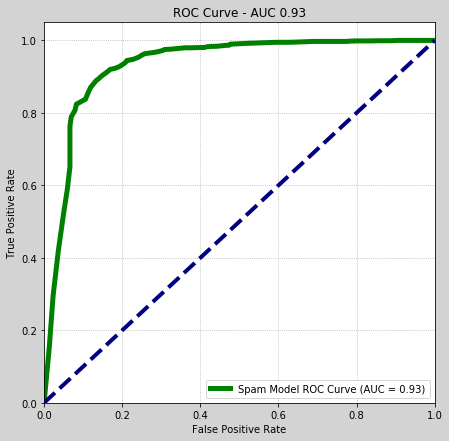

In [30]:
 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, prediction_probas[:, 1])
roc_auc = auc(fpr, tpr)


fig = plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='green',
         lw=5, label='Spam Model ROC Curve (AUC = %0.2f)' % roc_auc)
fig.set_facecolor('lightgray')
fig.set_edgecolor('black')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AUC %0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.grid(linestyle='dotted')

plt.show()


**Feature Importance**

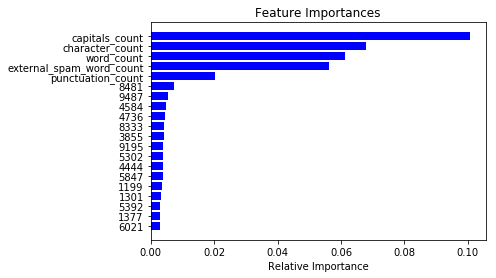

In [31]:
importance = rf_model.feature_importances_
zipped = zip(X_train.columns, importance)
importance = pd.DataFrame(sorted(zipped, key=lambda x: x[1], reverse=True)[0:20])
importance.columns = ['feature','importance']
importance = importance.sort_values('importance')

plt.title('Feature Importances')
plt.barh(range(len(importance)), importance['importance'], color='b', align='center')
plt.yticks(range(len(importance)), importance['feature'])
plt.xlabel('Relative Importance')
plt.show()


**Pickle needed files for web application**

In [32]:
import pickle
predictions = prediction_probas[:, 1]
actuals = list(y_test)

# packaging two different objects in one pickle
data = [actuals, predictions]
with open('spam_model_output.p', 'wb') as f:
    pickle.dump(data, f, 2)

In [33]:
actuals

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [34]:
# %%bash
# pip3 install git+https://github.com/mwaskom/seaborn.git
import seaborn as sns

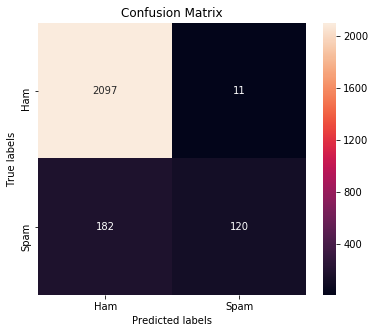

In [35]:
prediction_tmp = [1 if x >= 0.5 else 0 for x in prediction_probas[:, 1]]

# confusion matrix
labels = ['Ham','Spam']
cm = confusion_matrix(y_test, prediction_tmp, [1,0])
  
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()
 

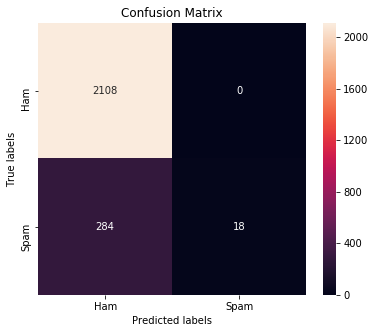

In [36]:
prediction_tmp = [1 if x >= 0.3 else 0 for x in prediction_probas[:, 1]]

# confusion matrix
labels = ['Ham','Spam']
cm = confusion_matrix(y_test, prediction_tmp, [1,0])
  
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [37]:
def rescale(orig_value, orig_set1, new_set2):
    oldRange = max(orig_set1) - min(orig_set1)
    newRange = max(new_set2) - min(new_set2)
    return(((orig_value -  min(orig_set1)) * newRange / oldRange) + min(new_set2))

smp_spam_actuals, prediction_tmp = [actuals, predictions]
new_thres = 0.5
prediction_tmp = [1 if x >= new_thres else 0 for x in predictions] 

cm = confusion_matrix(smp_spam_actuals, prediction_tmp, [1,0])
tp = cm[0][0] # correctly predicted as Spam
tn = cm[1][1] # correctly predicted as Ham
fp = cm[1][0] # incorrectly predicted as Spam when it was Ham - those hurt!
fn = cm[0][1] # incorrectly predicted as Ham when it was Spam - nuisance...

cm_details = [tp,tn,fp,fn]
cm_scaled_details = []
for cm_val in cm_details:
    if (cm_val > 0):
        cm_scaled_details.append(int(round(rescale(cm_val,[min(cm_details), max(cm_details)], [1, 11]))))
    else:
        cm_scaled_details.append(0)
cm_scaled_details
 


[11, 2, 2, 1]